In [11]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [12]:
from fastai.vision import *
from fastai.metrics import error_rate

In [13]:
bs = 64

In [18]:
data = ImageDataBunch.from_folder("./data" , size = 32, valid_pct= 0.15, seed = 42)

In [15]:
data

ImageDataBunch;

Train: LabelList (54543 items)
x: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: CategoryList
anime,anime,anime,anime,anime
Path: data;

Valid: LabelList (9625 items)
x: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: CategoryList
not_anime,not_anime,not_anime,not_anime,anime
Path: data;

Test: None

- [ ] Try Transforms.
- [ ] Try Size. Warning triggered when size argument is omitted. data.show_batch errors out without the size argument.
- [ ] Are Data Augmentations and Transforms entirely different things? If yes try Augmentation too.
- [ ] Try Normalization.
### Results:
- Without Transform:
- With Transform:
<hr>
- Without Size:
- With Size (32) :

- [ ] Check fastai notebooks for usual CIFAR10 batch sizes. 
- Size 32 does not look great.
- Size = (16,16), (32,32), (64,64) are not great either. Why do the 32x32 images look bad when CIFAR10 images are 32x32.
- Size = (120,120), (150,150) seem better for the anime images at least.
- Images look bad because 32x32 is really really small.

### data.show_batch errors out when the image sizes are different.

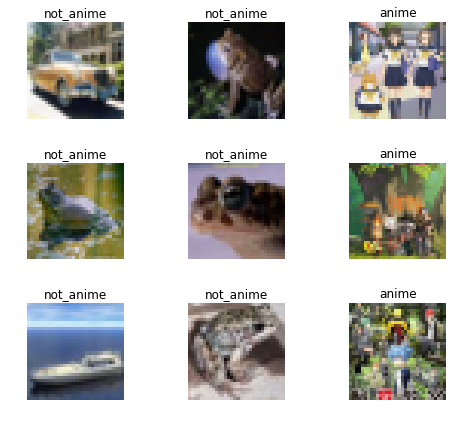

In [6]:
data.show_batch(rows=3, figsize=(7,6))

In [7]:
print(data.classes)

['anime', 'not_anime']


In [19]:
learn = cnn_learner(data, models.resnet34, metrics = error_rate)

In [20]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

epoch,train_loss,valid_loss,error_rate,time
0,0.186626,0.165829,0.059844,01:08
1,0.123703,0.110600,0.039169,00:41
2,0.093959,0.095250,0.033870,00:41
3,0.085756,0.090886,0.032519,00:41


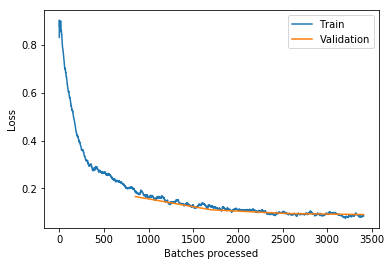

In [21]:
learn.fit_one_cycle(4)
learn.recorder.plot_losses()

In [22]:
learn.save('stage-1')

# Results:

We will now plot the images where the model was most confused.

In [23]:
interp = ClassificationInterpretation.from_learner(learn)

losses, idxs = interp.top_losses()

len(data.valid_ds) == len(losses) == len(idxs)

True

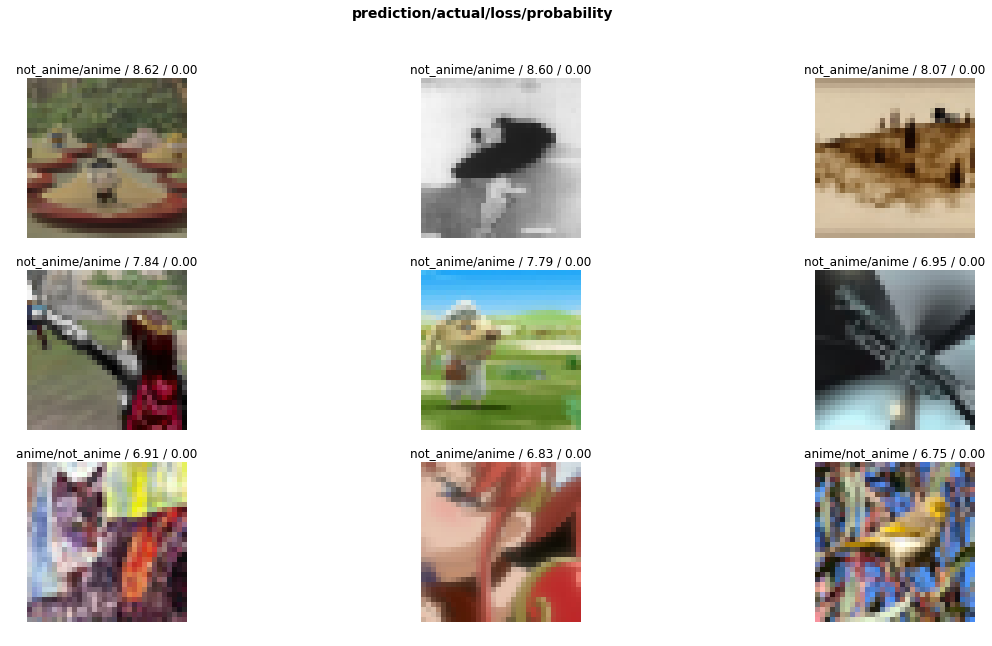

In [24]:
interp.plot_top_losses(9, figsize = (20,10))

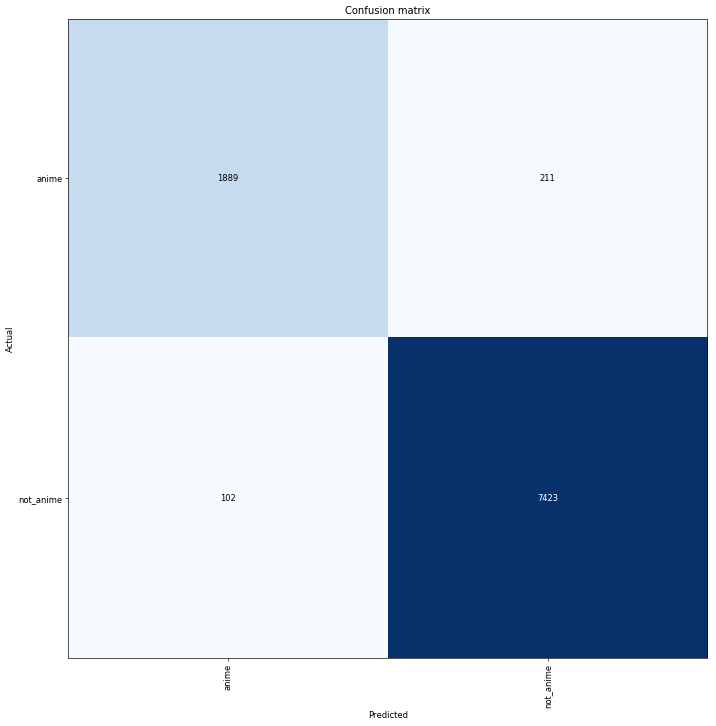

In [25]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

# Unfreezing, fine-tuning, and learning rates

If our model is wokring as expected, we will unfreeze our model and train some more.

In [26]:
learn.unfreeze()

epoch,train_loss,valid_loss,error_rate,time
0,0.055458,0.047947,0.015377,00:49


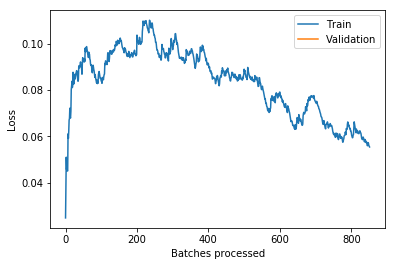

In [27]:
learn.fit_one_cycle(1)
learn.recorder.plot_losses()

In [33]:
learn.load('stage-1');

In [29]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


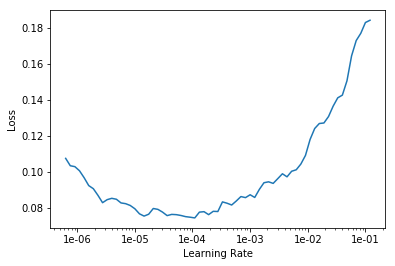

In [30]:
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,time
0,0.080244,0.092255,0.031481,00:51
1,0.070075,0.088667,0.029922,00:48
2,0.069725,0.077929,0.027013,00:49
3,0.048679,0.080807,0.026078,00:49
4,0.039339,0.078091,0.025766,00:50
5,0.038150,0.087356,0.026078,00:48
6,0.026977,0.083483,0.024519,00:50
7,0.027763,0.083058,0.024935,00:49


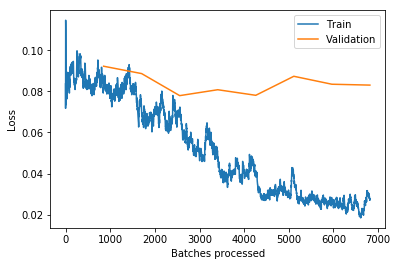

In [34]:
learn.unfreeze()
learn.fit_one_cycle(8, max_lr=slice(1e-6, 1e-4))
learn.recorder.plot_losses()

#  Trying resnet50 with bigger images and half the batch size:

In [35]:
data = ImageDataBunch.from_folder("./data" , size = 64, valid_pct= 0.15, seed = 42, bs = bs//2)

In [36]:
learn = cnn_learner(data, models.resnet50, metrics = error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


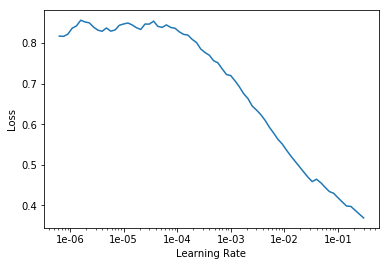

In [37]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,time
0,0.021114,0.010046,0.002701,01:42
1,0.002179,0.001472,0.000416,01:41
2,0.000744,0.000638,0.000208,01:42
3,0.000580,0.000006,0.000000,01:43
4,0.000061,0.000009,0.000000,01:41
5,0.000007,0.000039,0.000000,01:41
6,0.000005,0.000042,0.000000,01:44
7,0.000000,0.000019,0.000000,01:42


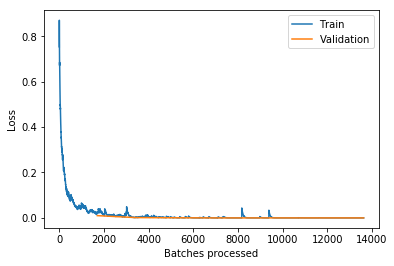

In [38]:
learn.fit_one_cycle(8)
learn.recorder.plot_losses()

### Throughout this notebook, our validation loss has been less than or equal to our train loss.
### Could this be because our validation set is highly biased towards non anime images?

In [39]:
learn.save('stage-1-50')

epoch,train_loss,valid_loss,error_rate,time
0,0.028315,0.007506,0.000416,02:03
1,0.005228,0.000001,0.000000,02:05
2,0.000000,0.000000,0.000000,02:04


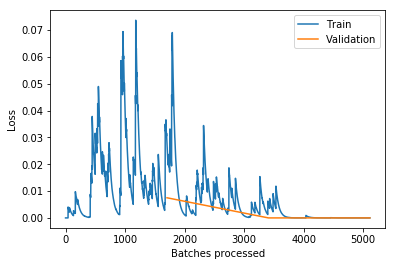

In [40]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-4,1e-2))
learn.recorder.plot_losses()